In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from tqdm import tqdm
import torch.optim as optim
import yaml
import pickle
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import pdb
import sys
sys.path.insert(0, '/home/andrea/Scrivania/Tesi/leonardo')
from data import dataset
from trainer import Trainer
from models.GCN_LSTM.model import GCN_LSTM

In [2]:
with open("/home/andrea/Scrivania/Tesi/leonardo/config_env.yaml", 'r') as f:
    config_env = yaml.safe_load(f)

id_model = "GCN-LSTM"
with open(os.path.join(config_env['paths']['config'], f"{id_model}.yaml"), 'r') as f:
    config = yaml.safe_load(f)
    
config.update(config_env)

if 'epochs' in config_env['setting'].keys():
    config['training']['epochs'] = config_env['setting']['epochs']


In [3]:
data = pd.read_csv(os.path.join(config['paths']['data'], 'covid.csv'), index_col=0)
data.data = pd.to_datetime(data.data, format="%Y-%m-%d %H:%M:%S.%f")
data.rename(columns = {'nuovi_casi':'y'}, inplace=True)

In [4]:
class dataset(Dataset):
    
    def __init__(self, 
                 df: pd.DataFrame,
                 past_step:int, 
                 future_step:int, 
                 past_variables: list, 
                 future_variables: list, 
                 y:list,
                 adj: np.array,
                 nodes: int, 
                 timedelta:str = 'D',
                 col_data: str = "data"):
        """
        Arguments:
            df (pandas.Dataframe): Path to the csv file with annotations.
            adj : adjacency matrix
            nodes : number of nodes
            past_step (int): previous step to look back
            future_step (int): future step to look for
            col_data (str): it indicate the columns that gives the indication about the time
        """

        self.x = []
        self.x_fut = []
        self.y = []
        self.adj = adj
        date = df[col_data].unique()
        date.sort()
        start = 0
        dt = np.diff(date[:past_step+future_step]) == np.timedelta64(1, timedelta)
        while any(not x for x in dt):
            start +=1
            dt = np.diff(date[start:past_step+future_step+ start]) == np.timedelta64(1, timedelta)
        
        for i in tqdm(range(start, len(date)-future_step-past_step-1)):
            if date[i+past_step+future_step]-date[i+past_step+future_step-1] == np.timedelta64(1, timedelta): 
                tmp_x = df[df[col_data].isin(date[i:i+past_step])].drop(columns = col_data).values
                tmp_y = df[df[col_data].isin(date[i+past_step:i+past_step+future_step])]
                
                self.x_fut.append(tmp_y[future_variables].values.reshape(future_step, nodes, -1))
                self.x.append(tmp_x.reshape(past_step, nodes, -1))
                self.y.append(tmp_y[y].values.reshape(future_step, -1))
            else:
                i += past_step+future_step
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.x_fut[idx], self.y[idx], self.adj

In [5]:
past_step = config['setting']['past_step']
future_step = config['setting']['future_step']
with open(os.path.join(config['paths']['adj'],"adj_totale.pkl"), "rb") as f:
    adj = pickle.load(f)
ds = dataset(df = data, 
             past_step = past_step,
             future_step = future_step, 
             nodes = len(data.codice_provincia.unique()),
             past_variables=data.columns.tolist(),
             future_variables = data.columns[-7:].tolist(), 
             y = ['y'],
             adj = adj, 
             timedelta = 'D')

100%|██████████████████████████████████████| 1215/1215 [00:05<00:00, 219.90it/s]


In [17]:
data[data.y<0].columns

Index(['data', 'daily_change_nuovi_casi',
       'daily_change_ricoverati_con_sintomi', 'daily_change_terapia_intensiva',
       'daily_change_totale_ospedalizzati',
       'daily_change_isolamento_domiciliare', 'daily_change_dimessi_guariti',
       'daily_change_deceduti', 'daily_change_codice_regione',
       'daily_change_codice_provincia', 'y', 'ricoverati_con_sintomi',
       'terapia_intensiva', 'totale_ospedalizzati', 'isolamento_domiciliare',
       'dimessi_guariti', 'deceduti', 'codice_regione', 'codice_provincia',
       'year', 'month', 'day', 'day_of_week', 'festivo'],
      dtype='object')

In [14]:
for past_step in [10,20,30,40]:
    for future_step in [10,20,30,50]:
        ds = dataset(df = data, 
             past_step = past_step,
             future_step = future_step, 
             nodes = len(data.codice_provincia.unique()),
             past_variables=data.columns.tolist(),
             future_variables = data.columns[-7:].tolist(), 
             y = ['y'],
             adj = adj, 
             timedelta = 'D')
        with open(os.path.join(config['paths']['data'], config['setting']['dataset'], f"{past_step}_{future_step}.pkl"), 'wb') as f:
            pickle.dump(ds, f)

  8%|███                                     | 96/1265 [00:00<00:05, 212.47it/s]

KeyboardInterrupt



In [6]:
len_train = int(len(ds)*0.75)
len_val = len(ds)-len_train
batch_size = 14
df_train, df_val = torch.utils.data.random_split(dataset=ds, lengths = [len_train, len_val])
dl_train = DataLoader(dataset=df_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(dataset=df_val, batch_size=batch_size, shuffle=True)
x_past, x_fut, y, adj = next(iter(dl_train))
config['setting']['in_feat_past'] = x_past.shape[-1]
config['setting']['in_feat_future'] = x_fut.shape[-1]
print(x_past.shape)
print(x_fut.shape)
print(y.shape)

torch.Size([14, 30, 107, 23])
torch.Size([14, 50, 107, 7])
torch.Size([14, 50, 107])


In [7]:
class embedding_layer(torch.nn.Module):
    def __init__(self,
                 categorical:list,
                 dim_categorical:int):
        
        super(embedding_layer, self).__init__()
        self.embedding = nn.ModuleList([nn.Embedding(categorical[i], dim_categorical) for i in range(len(categorical))])
    def forward(self, x):
    
        out = 0.0
        for i in range(len(self.embedding)):
            out += self.embedding[i](x[:,:,:, i])    
        return out.float()
        
class pre_processing(torch.nn.Module):
    def __init__(self,
                 in_feat:int, 
                 out_feat:int, 
                 dropout:float):
        
        super(pre_processing, self).__init__()
        self.linear = nn.Sequential(nn.Dropout(dropout),
                                    nn.Linear(in_features = in_feat, out_features = 128),
                                    nn.ReLU(), 
                                    nn.Linear(in_features = 128, out_features = 128),
                                    nn.ReLU(),
                                    nn.Linear(in_features = 128, out_features = out_feat, bias=False))
        
    def forward(self, x):  
        return self.linear(x.float())

class my_gat(torch.nn.Module):

    def __init__(self, 
                 in_channels: int, 
                 out_channels: int):
        super(my_gat, self).__init__()

        self.in_channels = in_channels
        self.a1 = nn.Parameter(torch.randn(out_channels))
        self.a2 = nn.Parameter(torch.randn(out_channels))
        self.emb = nn.Linear(in_features = in_channels, 
                             out_features = out_channels, 
                             bias = False)
        

    def forward(self,
                x0: tuple) -> torch.tensor:
        
        x, A = x0   
        x_emb = self.emb(x)
        _, _, N, _ = x_emb.shape
        ## <a,(h_i||h_j)>
        top = torch.einsum('bsnj,j->bsn', x_emb, self.a1)
        bot = torch.einsum('bsnj,j->bsn', x_emb, self.a2)
        z = F.leaky_relu(top.unsqueeze(-1)+bot.unsqueeze(-1).transpose(-2,-1))

        # Apply the mask to fill values in the input tensor
        # sigmoid(Pi*X*W)
        pi = F.softmax(z.masked_fill(A == 0., -float('infinity')), -1)
        x = F.sigmoid(torch.einsum('bpik,bpkj->bpij', pi, x_emb))        
        return (x, A)

class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        # LSTM weights and biases
        self.W_i = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_f = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_o = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_g = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, x, hidden):
        h_prev, c_prev = hidden
        
        # Concatenate input and previous hidden state
        combined = torch.cat((x, h_prev), dim=-1)

        # Compute the input, forget, output, and cell gates
        i = torch.sigmoid(self.W_i(combined))
        f = torch.sigmoid(self.W_f(combined))
        o = torch.sigmoid(self.W_o(combined))
        g = torch.tanh(self.W_g(combined))

        # Update the cell state and hidden state
        c = f * c_prev + i * g
        h = o * torch.tanh(c)

        return h, c
        
        
class GAT_LSTMseq2seq(torch.nn.Module):
    def __init__(self, 
                 in_feat_past:int, 
                 in_feat_fut:int, 
                 past: int, 
                 future: int,
                 categorical_past:list,
                 categorical_future:list,
                 device, 
                 out_preprocess:int = 128, 
                 dropout: float = 0.1, 
                 dim_categorical_past:int = 64, 
                 dim_categorical_future:int = 128, 
                 concat:bool = True,
                 num_layer_gnn_past:int = 1,
                 num_layer_gnn_future:int = 1,
                 out_gnn: int = 128, 
                 hidden_gnn:int = 256,
                 hidden_lstm: int = 128, 
                 hidden_propagation:int = 128):
        
        super(GAT_LSTMseq2seq, self).__init__()
        
        self.in_feat_past = in_feat_past         # numero di features di ogni nodo prima del primo GAT        
        self.in_feat_past = in_feat_fut
        self.past = past 
        self.future = future
        self.hidden_gnn = hidden_gnn
        self.hidden_lstm = hidden_lstm
        self.device = device
        self.categorical_past = categorical_past
        self.categorical_fut = categorical_future
        
        
        ########## PREPROCESSING PART #############        
        self.embedding_past = embedding_layer(categorical = categorical_past,
                                            dim_categorical = dim_categorical_past)
        if len(categorical_future)>0:
            self.embedding_future = embedding_layer(categorical = categorical_future,
                                                    dim_categorical = dim_categorical_future)
        
        in_feat_preprocessing_past = in_feat_past + dim_categorical_past - len(categorical_past)
        self.pre_processing_past = pre_processing(in_feat = in_feat_preprocessing_past, 
                                                 out_feat = out_preprocess, 
                                                 dropout = dropout)
        in_feat_preprocessing_fut = in_feat_fut + dim_categorical_future - len(categorical_future)
        self.pre_processing_fut = pre_processing(in_feat = in_feat_preprocessing_fut, 
                                                 out_feat = out_preprocess, 
                                                 dropout = dropout)
        ########## GNN ############# 
        ##### past
        layers = []
        for i in range(num_layer_gnn_past):
            layers.append(my_gat(in_channels = out_preprocess if i == 0 else hidden_gnn, 
                                 out_channels = out_gnn if i == num_layer_gnn_past-1 else hidden_gnn))            
        self.gnn_past = nn.Sequential(*layers)

        ##### future
        layers = []
        for i in range(num_layer_gnn_future):
            layers.append(my_gat(in_channels = out_preprocess if i == 0 else hidden_gnn, 
                                 out_channels = out_gnn if i == num_layer_gnn_future-1 else hidden_gnn))            
        self.gnn_future = nn.Sequential(*layers)

        ######### LSTM ################
        # sia l'embedding del passato che quello del futuro hanno la stessa dimensionalità
        # quindi poso usare lo stesso lstm e prendere come output gli ultimi `fut_step` 
        self.lstm = LSTMCell(input_size = out_gnn, 
                             hidden_size = hidden_lstm)
        self.decoding = nn.Sequential(nn.Linear(in_features = hidden_lstm, 
                                                out_features = hidden_propagation), 
                                      nn.ReLU(), 
                                      nn.Linear(in_features = hidden_propagation,
                                                out_features = hidden_propagation),
                                      nn.ReLU(),
                                      nn.Linear(in_features = hidden_propagation,
                                                out_features = 1))
               
    def forward(self, x_past, x_fut, adj):        
        ########### pre-processing dei dati ##########
        ##### past 
        emb = self.embedding_past(x_past[:,:,:,-len(self.categorical_past):].int())
        x_past = torch.cat((x_past[:,:,:,:-len(self.categorical_past)], emb), -1)
        x_past = self.pre_processing_past(x_past)
        
        ##### future
        if len(self.categorical_fut)>0:
            emb = self.embedding_future(x_fut[:,:,:,-len(self.categorical_fut):].int())
            x_fut = torch.cat((x_fut[:,:,:,:-len(self.categorical_fut)], emb), -1)    
        x_fut = self.pre_processing_fut(x_fut)
        
        ########## GNN processing ######################
        x_past, _ = self.gnn_past((x_past, adj))
        x_fut, _ = self.gnn_future((x_fut, adj))

        ########## LSTM part ###########################
        x_lstm = torch.cat((x_past, x_fut), 1)
        batch_size, seq_len, nodes, features = x_lstm.size()
        h, c = [torch.zeros(batch_size, nodes, self.hidden_lstm).to(x_past.device)] * 2
        out = []
        for t in range(seq_len):
            h, c = self.lstm(x_lstm[:, t], (h, c)) 
            if t >= self.past:
                out.append(self.decoding(c))
        out = torch.cat(out, -1)
        return out.transpose(-2,-1)

device = torch.device("cpu")       
model = GAT_LSTMseq2seq(in_feat_past = config['setting']['in_feat_past'],
                        in_feat_fut = config['setting']['in_feat_future'],
                        past = past_step,
                        future = future_step,
                        categorical_past = config['categorical'][config['setting']['dataset']]['past'],
                        categorical_future = config['categorical'][config['setting']['dataset']]['future'],
                        device = device).to(device)
yh = model(x_past.to(model.device),x_fut.to(model.device), adj[0].to(model.device))
yh.shape

torch.Size([14, 50, 107])

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GAT_LSTMseq2seq(in_feat_past = config['setting']['in_feat_past'],
                        in_feat_fut = config['setting']['in_feat_future'],
                        past = past_step,
                        future = future_step,
                        categorical_past = config['categorical'][config['setting']['dataset']]['past'],
                        categorical_future = config['categorical'][config['setting']['dataset']]['future'],
                  device = device).to(device)

In [9]:
optimizer = optim.Adam(model.parameters(), 
                       lr = 1e-4, 
                       weight_decay=2e-4)

def linfty(y, yh, gamma = 1.0, alpha=1e-1, beta=1e-0):
    out = 0.5*F.l1_loss(y,yh, reduction = "mean")
    out += gamma*F.mse_loss(y,yh, reduction = "mean")
    out += alpha*torch.max(torch.abs(y-yh))
    out += beta*(torch.sum(F.relu(-yh)))
    return out

In [10]:
trainer = Trainer(model = model.to(device), 
                  PATH = os.path.join(config['paths']['models'], "testing.pt"), 
                  optimizer = optimizer, 
                  gamma_scheduler = 0.85, 
                  step= 300, 
                  loss_function = linfty)

trainer.fit(train_loader=dl_train, val_loader=dl_val, epochs=45)

  2%|▉                                        | 1/45 [04:26<3:15:06, 266.06s/it]

loss train epoch 1 == 1947966.5321784741
loss val epoch 1 == 1655259.0532670454


  4%|█▊                                       | 2/45 [08:51<3:10:34, 265.92s/it]

loss train epoch 2 == 1927175.6519886365
loss val epoch 2 == 1624380.8920454546


  7%|██▋                                      | 3/45 [13:17<3:06:07, 265.89s/it]

loss train epoch 3 == 1909087.8732244319
loss val epoch 3 == 1640110.0539772727


  9%|███▋                                     | 4/45 [17:43<3:01:39, 265.83s/it]

loss train epoch 4 == 1915502.4740767046
loss val epoch 4 == 1580907.5340909092


 11%|████▌                                    | 5/45 [22:09<2:57:11, 265.79s/it]

loss train epoch 5 == 1870623.8735795454
loss val epoch 5 == 1558161.4865056819


 13%|█████▍                                   | 6/45 [26:34<2:52:44, 265.75s/it]

loss train epoch 6 == 1856913.3458806819
loss val epoch 6 == 1547506.8114346592


 16%|██████▍                                  | 7/45 [31:00<2:48:17, 265.73s/it]

loss train epoch 7 == 1871484.6337594697
loss val epoch 7 == 1539879.9559659092


 16%|██████▍                                  | 7/45 [33:13<3:00:21, 284.77s/it]

KeyboardInterrupt



In [11]:
def plot(model, 
         config:yaml,
         loss_training: list, 
         loss_validation: list, 
         name:str,
         dl_train: DataLoader,
         dl_val: DataLoader, 
         show = False):

    fig = px.line({"epochs": range(1,len(loss_training)+1), 
                                   "train": loss_training, 
                                   "validation": loss_validation}, 
                                  x = "epochs", 
                                  y = ["train", "validation"], 
                                  title= f"training loss for {name}")
    fig.add_vline(x = np.argsort(loss_validation)[0]+1)
    fig.add_hline(y = np.min(loss_validation))
    fig.write_html(os.path.join(config['paths']['fig'], config['setting']['dataset'], f"loss_gnn_{name}.html"))
    if show:
        fig.show()
    model = model.cpu()
    model.device = torch.device('cpu')
    
    x_past_train, x_fut_train, y_train, adj_train = next(iter(dl_train))
    x_past_val, x_fut_val, y_val, adj_val = next(iter(dl_val))
    yh_train = model(x_past_train.float().to(model.device), x_fut_train.float().to(model.device), adj_train[0].to(model.device)).detach().numpy()
    yh_val = model(x_past_val.float().to(model.device), x_fut_val.float().to(model.device), adj_val[0].to(model.device)).detach().numpy()

    fig, ax = plt.subplots(nrows = y_val.shape[1], 
                           ncols = 2, 
                           constrained_layout = True,
                           figsize = (20, 3*y_val.shape[1]))
    
    for day in range(y_val.shape[1]):
        ax[day, 0].plot(yh_train[0,day], label = "estimate")
        ax[day, 0].plot(y_train[0,day], label ="real")
    
        ax[day, 1].plot(yh_val[0,day], label = "estimate")
        ax[day, 1].plot(y_val[0,day], label ="real")
        ax[day, 0].legend()
        ax[day, 1].legend()
    
        ax[day, 0].title.set_text(f"day {day +1} train")
        ax[day, 1].title.set_text(f"day {day +1} validation")
    fig.suptitle(' Comparison between estimation and reality ', fontsize=20) 
    
    path = os.path.join(config['paths']['fig'], config['setting']['dataset'], f"{name}.png")
    plt.savefig(path)
    if show:
        plt.show()
    plt.close(fig)

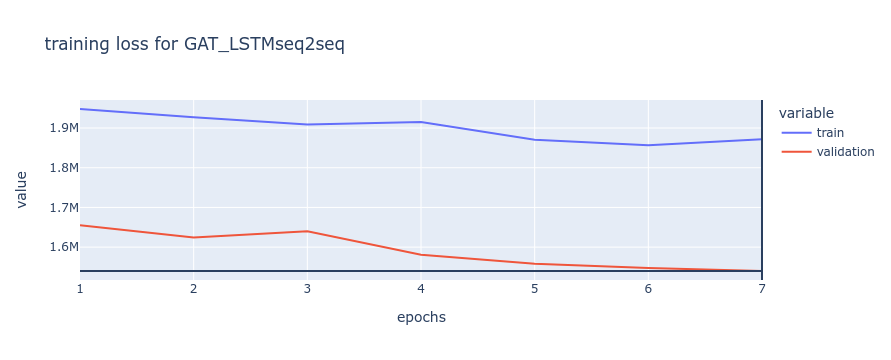

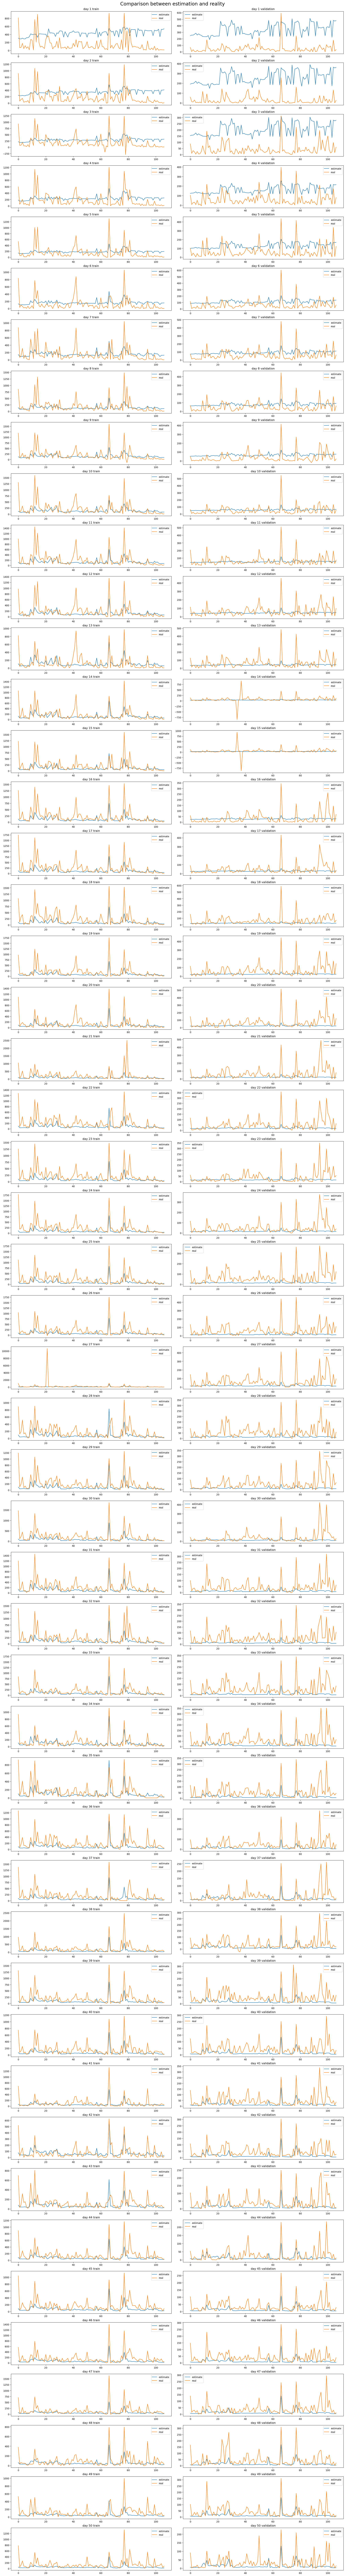

In [12]:
id_model = "GAT_LSTMseq2seq"
plot(model = trainer.model,
     config = config,
     loss_training = trainer.loss_train, 
     loss_validation = trainer.loss_val, 
     dl_train = dl_train, 
        dl_val = dl_val, 
        name = f"{id_model}", 
        show = True)

In [ ]:
def plot_stream(model, 
         config,
         loss_training, 
         loss_validation, 
         name,
         time_step:int, 
         data:pd.DataFrame, 
         show = False):
    fig = px.line({"epochs": range(1,len(loss_training)+1), 
                                   "train": loss_training, 
                                   "validation": loss_validation}, 
                                  x = "epochs", 
                                  y = ["train", "validation"], 
                                  title= f"training loss for {name}")
    fig.add_vline(x = np.argsort(loss_validation)[0]+1)
    fig.add_hline(y = np.min(loss_validation))
    fig.write_html(os.path.join(config['paths']['fig'], f"loss_gnn_{name}.html"))
    if show:
        fig.show()
    
    past_step = model.past
    future_step = model.future
    date = np.sort(data.data.unique())
    y = []
    yh = []
    x_date = []
    start = 0
    dt = np.diff(date[:past_step+future_step]) == np.timedelta64(1, timedelta)
    while any(not x for x in dt):
        start +=1
        dt = np.diff(date[start:past_step+future_step+ start]) == np.timedelta64(1, timedelta)
    
    for i in tqdm(range(start, len(date)-future_step-past_step-1)):
        if date[i+past_step+future_step]-date[i+past_step+future_step-1] == np.timedelta64(1, timedelta): 
            x = data[data.data.isin(date[i:i+past_step])].drop(columns = 'data').values
            x = x.reshape(1, past_step, n_nodes, config['setting']['in_feat'])
            tmp = data[data.data.isin(date[i+past_step:i+past_step+future_step])].y.values
            y.append(tmp.reshape(1, future_step, n_nodes))
            yh.append(F.relu(model(torch.from_numpy(x).to(model.device), adj[0].to(model.device)).detach()).cpu())
        else:
             i += past_step+future_step 
    
    yh = torch.cat(yh,0)
    y = np.vstack(y) 
    f = y.shape[-1]
    for step in range(model.future):
        fig, ax = plt.subplots(nrows = f, 
                                   ncols = 1, 
                                   constrained_layout = True,
                                   figsize = (20,f*3))
    
        for n in range(f):
            ax[n].plot(y[:,step,n], label = 'real')
            ax[n].plot(yh[:,step, n], label = 'estimated')
            ax[n].legend()  

            err = np.mean(np.abs(yh[:,step, n].numpy()-y[:,step, n]))
            ax[n].title.set_text(f"node {n}, step {step} train, err = {err}")
        
        path = os.path.join(config['paths']['fig_flows'], f"{name}", f"step{step+1}.png")
        plt.savefig(path)
        plt.close()


In [ ]:
plot_stream(trainer.model,
     config,
     trainer.loss_train, 
     trainer.loss_val, 
     name = "GCN_LSTM", 
     time_step = 3, 
     data = data, 
     show = True)